In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform
from datetime import timedelta

## Problem Statement

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption.

We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data you  think  would  be  valuable.

#### Data Description
The  data  has  the  following  two  tables:

1)  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one
of  5  values:
    1. PERSONAL_PROJECTS:  invited  to  join  another  user's
personal  workspace
    2. GUEST_INVITE:  invited  to  an  organization  as  a  guest
(limited  permissions)
    3. ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    4. SIGNUP:  signed  up  via  the  website
    5. SIGNUP_GOOGLE_AUTH:  signed  up  using  Google
Authentication  (using  a  Google  email  account  for  their  login
id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable)

2)  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

## Load Data

In [2]:
df_user=pd.read_csv('./Data/takehome_users.csv', encoding='latin-1')

In [3]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
df_user.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [5]:
df_log=pd.read_csv('./Data/takehome_user_engagement.csv')

In [6]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
df_log.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

## Data Wrangling

#### Label Adopted Users

Defining an "adopted user" as a user who  has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [8]:
df_log['time_stamp'] = pd.to_datetime(df_log['time_stamp'])

In [9]:
adopted_users=df_log.sort_values('time_stamp').groupby('user_id').rolling('7D', on='time_stamp')['visited'].count()
unique_adopted_users=set([pair[0] for pair in adopted_users[adopted_users>=3].index.tolist()])
len(unique_adopted_users)

1602

In [10]:
df_user['adopted']=df_user['object_id'].isin(unique_adopted_users).astype(int)
df_user.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


#### Rename object_id column

In [11]:
df_user.rename(columns={'object_id': 'user_id'}, inplace=True)

#### String to Timestamp

In [12]:
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])

#### Extract Email Domains

There exists a lot of nonsense email domains, in order to turn this column into a categorical without too many options, all the uncommonly used email domains will be relabeled as 'other'

In [13]:
df_user['email_domain'] = df_user['email'].str.split('@').str[1]
df_user['email_domain'].value_counts(ascending=False).head(10)

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
Name: email_domain, dtype: int64

In [14]:
def replace_domain(x):
    if x in ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']:
        return x
    else:
        return 'other'
df_user['email_domain']=df_user['email_domain'].apply(replace_domain)

#### 'last_session_creation_time' from Unix to Datetime

In [15]:
df_user['last_session_creation_time']=pd.to_datetime(df_user['last_session_creation_time'], unit='s', origin='unix')

In [56]:
df_user.last_session_creation_time.sort_values(ascending=False)

4050    2014-06-06 14:58:50
340     2014-06-04 23:56:26
9557    2014-06-04 23:46:31
9324    2014-06-04 23:34:04
4624    2014-06-04 23:32:13
                ...        
4399    2012-05-31 22:50:00
4319    2012-05-31 21:26:00
7200    2012-05-31 18:12:00
9898    2012-05-31 17:19:37
10011   2012-05-31 08:20:06
Name: last_session_creation_time, Length: 12000, dtype: datetime64[ns]

#### Filling NaNs in 'invited_by_user_id' Column

In [16]:
df_user.invited_by_user_id.isna().sum()

5583

In [17]:
df_user.invited_by_user_id.fillna(0,inplace=True)
df_user['invited_by_user_id']=df_user['invited_by_user_id'].astype(int)
df_user.invited_by_user_id.isna().sum()

0

#### Filling NaNs in 'last_session_creation_time' Column

In [18]:
df_user.last_session_creation_time.isna().sum()

3177

In [19]:
df_user.last_session_creation_time.fillna(df_user.creation_time, inplace=True)
df_user.last_session_creation_time.isna().sum()

0

#### Creating 'days_between_creation_and_last_session' Column

In [20]:
df_user['days_between_creation_and_last_session']=(df_user.last_session_creation_time-df_user.creation_time).dt.days

#### Number of People Referred

In [21]:
invited_count=df_user.invited_by_user_id.value_counts().reset_index()
invited_count.columns=['user_id', 'people_referred']
invited_count.head()

,user_id,people_referred
0,0,5583
1,10741,13
2,2527,12
3,1525,11
4,2308,11


In [22]:
df_user=df_user.merge(invited_count, how='left', on='user_id')

In [23]:
df_user.people_referred.fillna(0, inplace=True)

#### 'org_id' Prevalance

In [24]:
org_prev=df_user.org_id.value_counts().reset_index()
org_prev.columns=['org_id', 'org_prevalance']
org_prev.head()

,org_id,org_prevalance
0,0,319
1,1,233
2,2,201
3,3,168
4,4,159


In [25]:
df_user=df_user.merge(org_prev, how='left', on='org_id')

#### Dropped Unneeded Columns

In [26]:
df_user.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'email_domain', 'days_between_creation_and_last_session',
       'people_referred', 'org_prevalance'],
      dtype='object')

In [27]:
drop_col=['user_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id', 'invited_by_user_id']
df=df_user.drop(columns=drop_col, axis=1)

## EDA

In [28]:
df['adopted'].value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

#### Tables for Categorical Variables

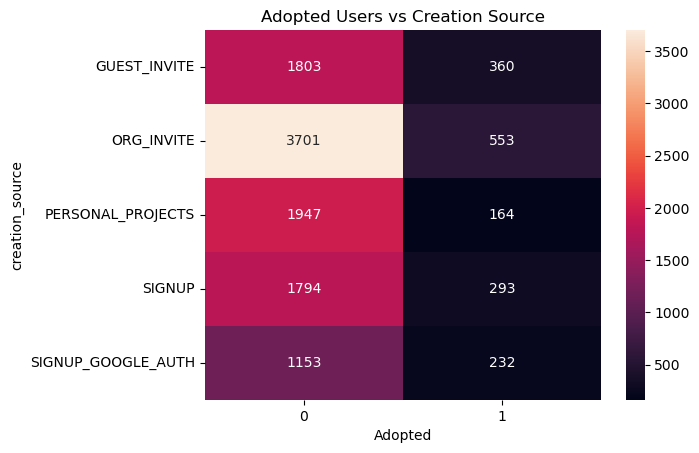

In [30]:
cross_tab = pd.crosstab(df['creation_source'], df['adopted'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('creation_source')
plt.xlabel('Adopted')
plt.title('Adopted Users vs Creation Source')
plt.show()

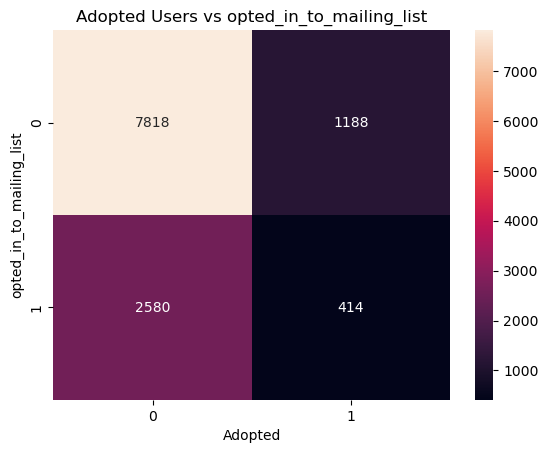

In [32]:
cross_tab = pd.crosstab(df['opted_in_to_mailing_list'], df['adopted'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('opted_in_to_mailing_list')
plt.xlabel('Adopted')
plt.title('Adopted Users vs opted_in_to_mailing_list')
plt.show()

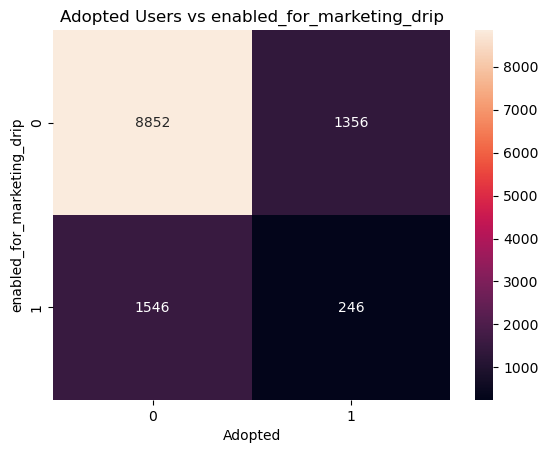

In [33]:
cross_tab = pd.crosstab(df['enabled_for_marketing_drip'], df['adopted'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('enabled_for_marketing_drip')
plt.xlabel('Adopted')
plt.title('Adopted Users vs enabled_for_marketing_drip')
plt.show()

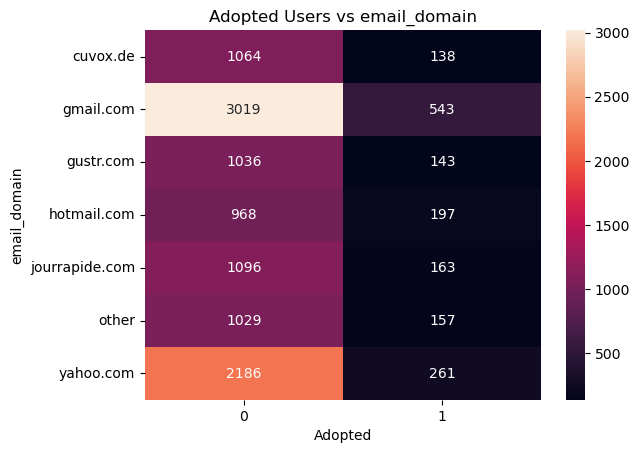

In [34]:
cross_tab = pd.crosstab(df['email_domain'], df['adopted'])
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.ylabel('email_domain')
plt.xlabel('Adopted')
plt.title('Adopted Users vs email_domain')
plt.show()

#### Boxplots

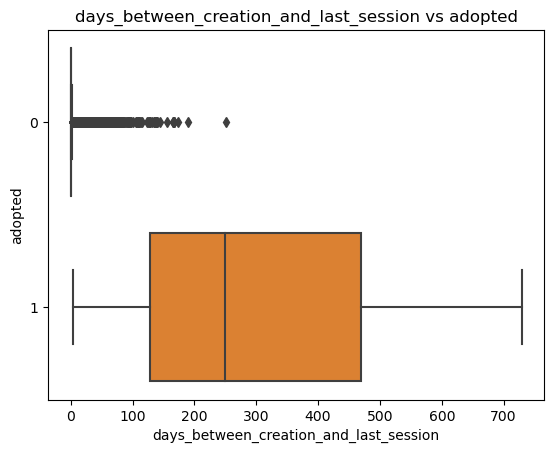

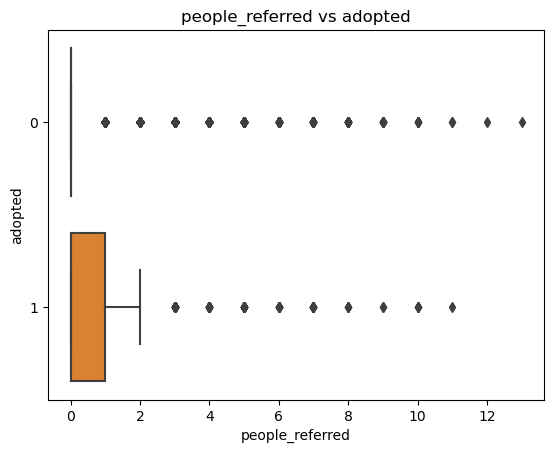

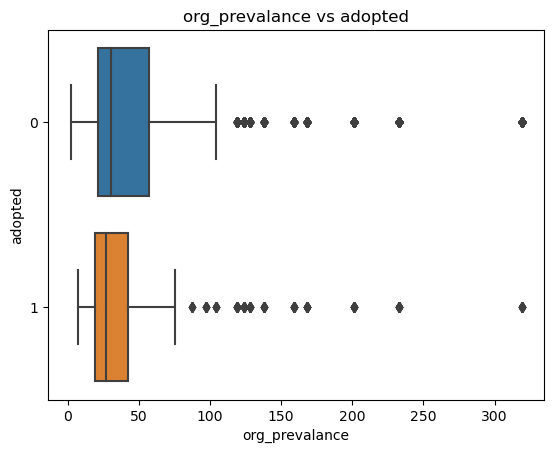

In [35]:
for feature in df.columns:
    if feature in ('creation_source','opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'email_domain', 'adopted'):
        continue
    sns.boxplot(data=df, x=feature, y=df.adopted.astype('category'), saturation=.7)
    plt.title(feature+ ' vs adopted')
    plt.show()

#### Feature Distributions

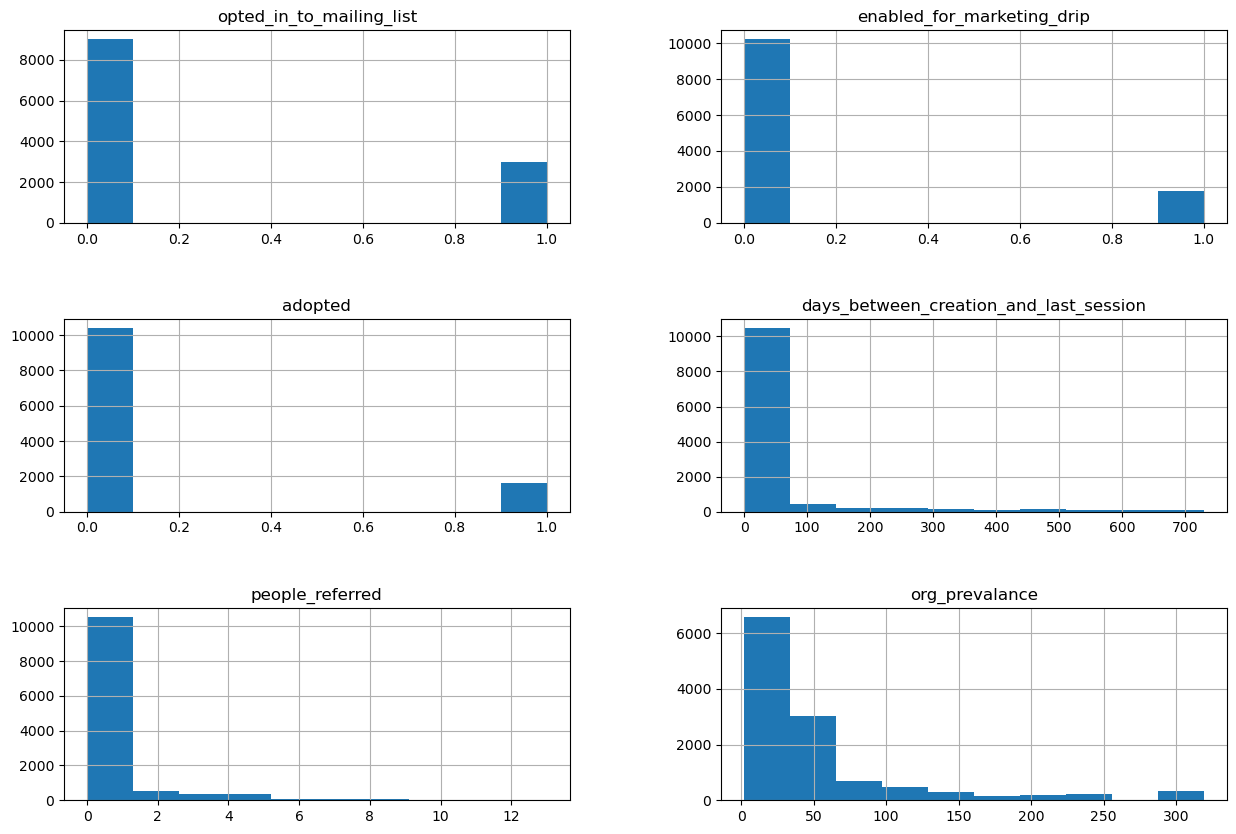

In [36]:
df.hist(figsize=(15,10), xrot=0)
plt.subplots_adjust(hspace=0.5);

#### Correlation Heatmap

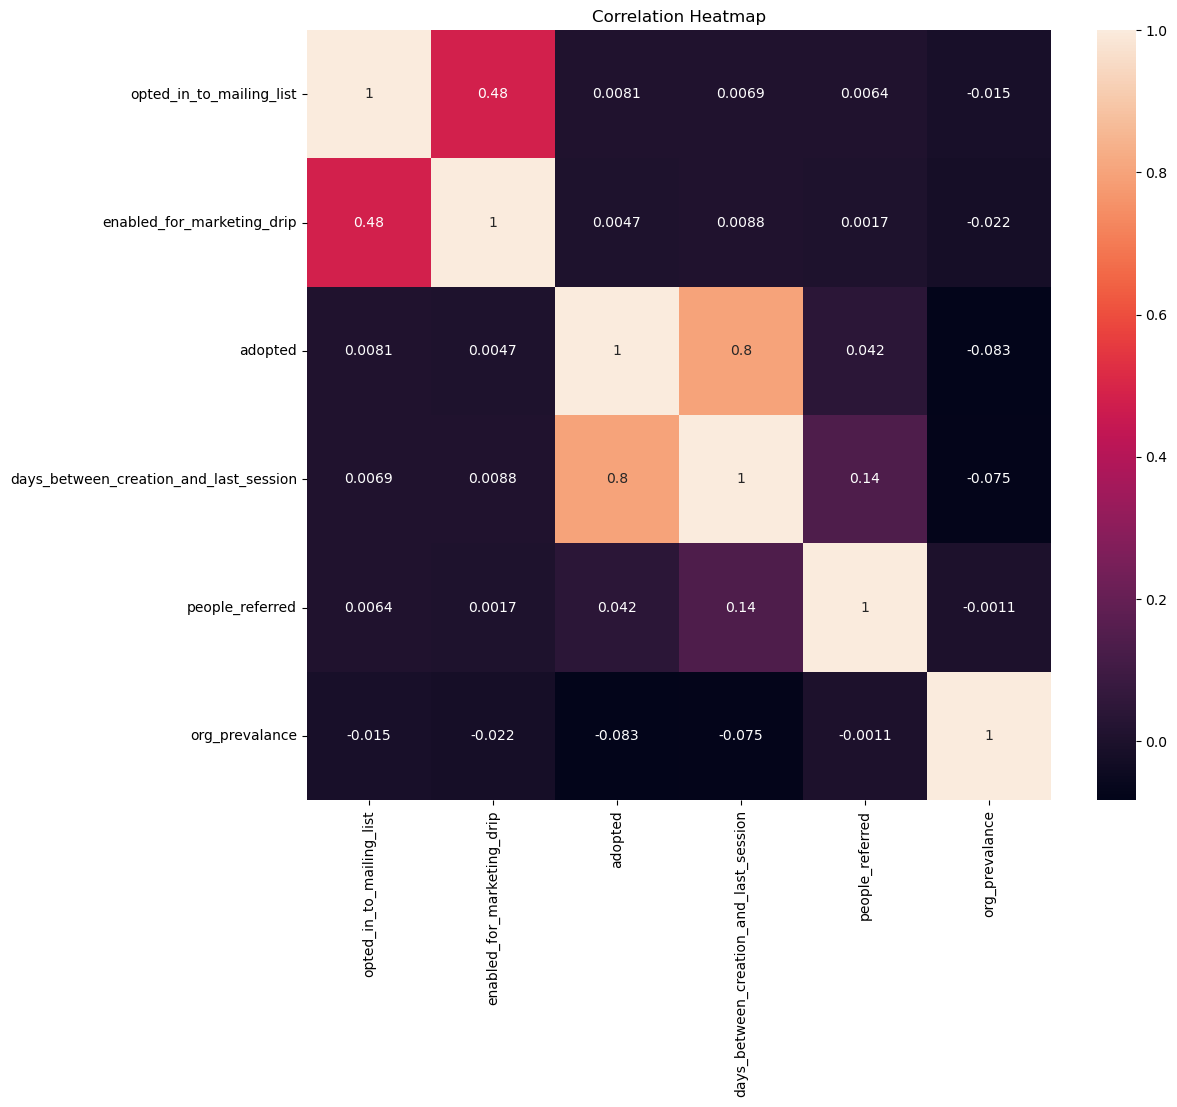

In [37]:
plt.subplots(figsize=(12,10))
plt.title('Correlation Heatmap')
sns.heatmap(df.drop(columns=['creation_source', 'email_domain']).corr(), annot=True);

## Preprocessing

#### Dummy Encoding

In [38]:
dummies=pd.get_dummies(df[['creation_source', 'email_domain']], drop_first=True, dtype=int)
dummies=pd.concat([df, dummies], axis=1)
dummies.drop(['creation_source', 'email_domain'],axis=1, inplace=True)
dummies.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,days_between_creation_and_last_session,people_referred,org_prevalance,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com
0,1,0,0,0,0.0,75,0,0,0,0,0,0,0,0,0,1
1,0,0,1,136,0.0,233,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1.0,32,1,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0.0,233,0,0,0,0,0,0,0,0,0,1
4,0,0,0,5,0.0,16,0,0,0,0,0,0,0,0,0,1


#### Train Test Split

In [39]:
response=dummies['adopted']
X=dummies.drop(columns='adopted', axis=1)
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X, response, test_size=.25,random_state=123)

## Modeling

In [40]:
scores=[]

In [41]:
def train_model_RandomizedSearch(X_train, y_train, steps, parameters):
    '''
    Trains a model using RandomizedSearchCV
    ---Parameters---
    X_train (pandas DataFrame) training features
    y_train (pandas Series) training target classes
    steps (list) steps used in pipeline
    parameters (dictionary) dictionary of hyperparameters to tune using GridSearchCV
    ---Returns---
    cv (sklearn classifier) fitted model
    '''
    pipe=Pipeline(steps)
    kf=KFold(n_splits=5, shuffle=True, random_state=123)
    cv=RandomizedSearchCV(pipe, param_distributions=parameters, cv=kf, scoring='accuracy', n_iter=50, random_state=123, n_jobs=-1)
    cv.fit(X_train,y_train)
    return cv

def record_results(model_name, cv, X_test, y_test):
    '''
    Records metrics for given classifier
    ---Parameters---
    model_name (str) name of model
    cv (sklearn classifier) fitted classifier
    X_test (pandas DataFrame) test features
    y_test (pandas Series) test target classes
    threshold (float) probability threshold for positive class
    ---Returns---
    list of metrics for classifier 
    '''
    y_pred=(cv.predict(X_test))
    y_prob=cv.predict_proba(X_test)[:,1]
    f1=f1_score(y_test,y_pred, average='binary')
    test_acc=accuracy_score(y_test,y_pred)
    roc=roc_auc_score(y_test, y_prob)
    precision= precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    return [model_name, f1, test_acc, roc, precision, recall]

In [42]:
num_features=X_train.shape[1]
RF_steps=[('randomForest', RandomForestClassifier(random_state=123))]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(3,20),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv=train_model_RandomizedSearch(X_train, y_train, RF_steps, RF_parameters)
RF_cv.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 5,
 'randomForest__max_features': 14,
 'randomForest__min_samples_leaf': 9,
 'randomForest__min_samples_split': 7,
 'randomForest__n_estimators': 87}

In [43]:
RF_cv.best_score_

0.9748888888888889

In [44]:
RF_results=record_results('Random Forest', RF_cv, X_test, y_test)
scores.append(RF_results)

In [45]:
results= pd.DataFrame(scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc','precision', 'recall'])
results

,Model Name,f1 score,test_acc,roc,precision,recall
0,Random Forest,0.916767,0.977,0.996287,0.945274,0.88993


In [49]:
def plot_feature_importance(importance, names, model_name):
    '''
    Visualizes a bar plot showing feature importance
    ---Parameters---
    importance (np array, pd series, list) coefficients or values of feature importance
    names (np array, pd series, list of str) corresponding feature names
    ---Returns---
    bp (sns.barplot object)
    '''
    data = {'feature_names': names, 'feature_importance': importance}
    df = pd.DataFrame(data, columns=['feature_names', 'feature_importance'])
    df['abs'] = df['feature_importance'].apply(lambda x: abs(x))
    df.sort_values(by=['abs'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    bp = sns.barplot(data=df, x='feature_importance', y='feature_names')
    
    # Add value of 'x' to each bar
    for p in bp.patches:
        width = p.get_width()
        bp.annotate(f'{width:.4f}', (width, p.get_y() + p.get_height() / 2),
                xytext=(35, 0), textcoords='offset points',
                ha='right', va='center')

    plt.tight_layout(pad=1.6)
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    return bp

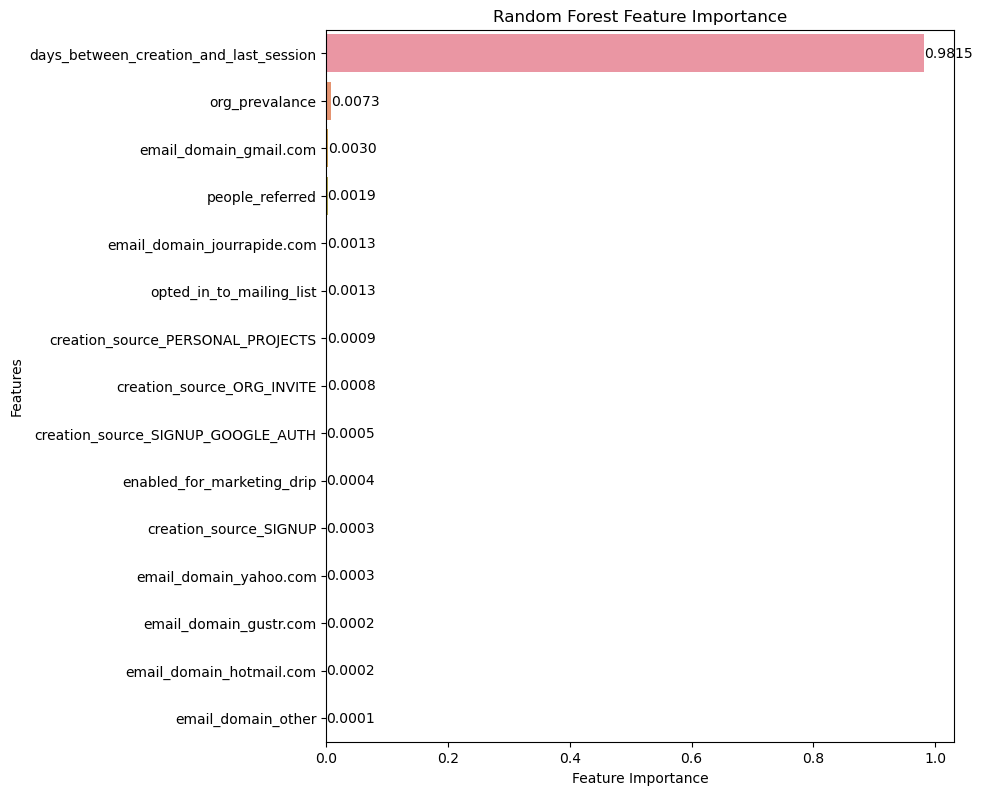

In [50]:
pfi=plot_feature_importance(importance, X_train.columns, 'Random Forest')